<a href="https://colab.research.google.com/github/p73rl11zq/AI4Sea/blob/main/AI4Sea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torch
import random
import numpy as np

import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

!pip install category_encoders
from category_encoders.binary import BinaryEncoder;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 1.9 MB/s eta 0:00:00


In [ ]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

> # **Challenge info**



All data about challenge available via the link:
https://dsworks.ru/champ/545de8cb-e023-4b64-9be4-b95b9519f8d3#overview

> # **Data reading**



In [ ]:
from google.colab import drive
drive.mount('/content/drive') # force_remount=True

Mounted at /content/drive


In [ ]:
pollok_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI4Sea/data/polock_dataset_train.csv', 
                        parse_dates=['date', 'datetimes'], dayfirst=True) 
pollok_df = pollok_df.drop(['Unnamed: 0'], axis=1) 

Filling the missing values (bfill/ffill, interpolation):

In [ ]:
pollok_df['course'] = pollok_df.groupby('idves')['course'].bfill(limit=1).ffill(limit=1)
pollok_df['course'] = pollok_df.groupby('idves')['course'].apply(lambda x: x.interpolate(method='linear'))

pollok_df['velocity'].fillna(pollok_df.groupby('idves')['velocity'].transform('median'), inplace = True)

df_edit = pollok_df.copy()

> # **'Raw' df processing**

## **Datetimes (timestamp)**

In [ ]:
df_edit['year'] = df_edit['datetimes'].dt.year 
df_edit['month'] = df_edit['datetimes'].dt.month
df_edit['day'] = df_edit['datetimes'].dt.day
df_edit['hour'] = df_edit['datetimes'].dt.hour
df_edit['minute'] = df_edit['datetimes'].dt.minute
df_edit['abs_minute'] = df_edit.hour*60 + df_edit.minute

Extract lenght of every voyage for every ship:

In [ ]:
df1 = pd.DataFrame({'count' : df_edit.groupby(["idves", "date"]).size()}).reset_index().sort_values(by='date')
df1.head(3)

,idves,date,count
768,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29,24
361,7463afe23eae7efe3c72737a5d3d693f,2003-02-08,26
821,fc84ad56f9f547eb89c72b9bac209312,2003-02-13,28


Marking all voyages in ascend order:

In [ ]:
df_edit['num_of_voyage'] = 1
temp = df_edit['num_of_voyage']

In [ ]:
step = 0
voyage = 1

for j in df1['count']:
    
    for i in range(j):
        temp[step+i] = voyage

    voyage += 1
    step += j

df_edit['num_of_voyage'] = temp

<ipython-input-88-67e57eb22897>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[step+i] = voyage


Normalization for date features:

In [ ]:
# Decimal-normalization
num_of_voyage = df_edit['num_of_voyage']
dec = num_of_voyage.max().round(-3)
num_of_voyage = df_edit['num_of_voyage'] / dec

In [ ]:
day = df_edit['day']
month = df_edit['month']
year = df_edit['year']

hour = df_edit['hour']
minute = df_edit['minute']
abs_minute = df_edit['abs_minute']

In [ ]:
day = day/day.abs().max()
print(day.min(), day.max())

month = (month - month.min()) / (month.max() - month.min())
print(month.min(), month.max())

#year = (year - year.min()) / (year.max() - year.min())
year = (year - year.mean()) / year.std()
print(year.min(), year.max())

0.03225806451612903 1.0
0.0 1.0
-3.9731325658697565 0.7955639040274688


In [ ]:
hour = hour/hour.abs().max()
print(hour.min(), hour.max())

minute = minute/minute.abs().max()
print(minute.min(), minute.max())

abs_minute = abs_minute/abs_minute.abs().max()
print(abs_minute.min(), abs_minute.max())

0.0 1.0
0.0 1.0
0.0 1.0


Scaling apply:

In [ ]:
df_edit['num_of_voyage'] = num_of_voyage
df_edit['day'] = day
df_edit['month'] = num_of_voyage
df_edit['year'] = year
df_edit['hour'] = hour
df_edit['minute'] = minute
df_edit['abs_minute'] = abs_minute

df_edit = df_edit.drop(['date', 'datetimes'], axis=1)

## **Idinf (coordinate source code):**

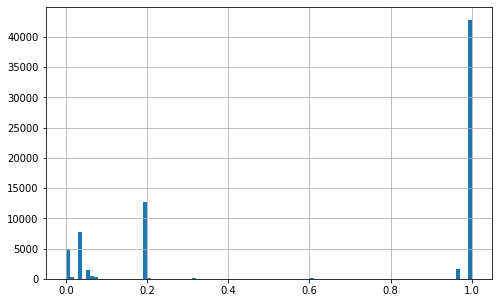

In [ ]:
pd.Series(df_edit['idinf']).hist(bins=100, figsize=(8,5))

Maximum absolute scaling apply:

In [ ]:
df_edit['idinf'] = df_edit['idinf'] / df_edit['idinf'].abs().max()
df_edit['idinf'].min(), df_edit['idinf'].max()

(0.0, 1.0)

## **Latitude & longitude (*, decimal)**

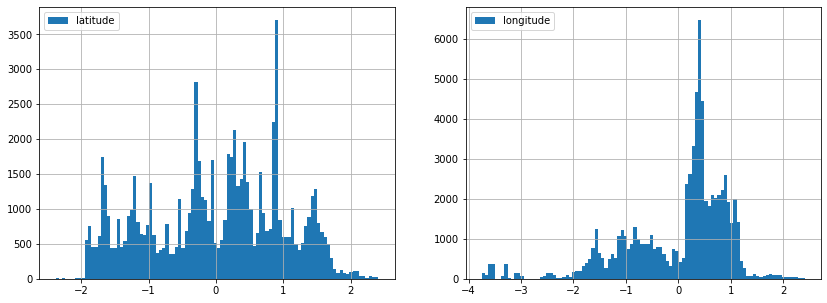

In [ ]:
plot, axis = plt.subplots(1, 2, figsize=(14,5))

axis[0].hist(df_edit['latitude'],bins=100);
axis[0].grid(visible=True)

axis[1].hist(df_edit['longitude'],bins=100);
axis[1].grid(visible=True)

axis[0].legend(['latitude'], loc='upper left')
axis[1].legend(['longitude'], loc='upper left')

Min-max normalization apply:

In [ ]:
# df_edit['latitude'] = (df_edit['latitude'] - df_edit['latitude'].min()) / (df_edit['latitude'].max() - df_edit['latitude'].min())
# df_edit['longitude'] = (df_edit['longitude'] - df_edit['longitude'].min()) / (df_edit['longitude'].max() - df_edit['longitude'].min())

df_edit['latitude'] = (df_edit['latitude'] - df_edit['latitude'].mean()) / df_edit['latitude'].std()
df_edit['longitude'] = (df_edit['longitude'] - df_edit['longitude'].mean()) / df_edit['longitude'].std()

## **Region (fishing subzone, categorical):**

In [ ]:
df_edit.region.unique()

array([274, 273, 272, 275])

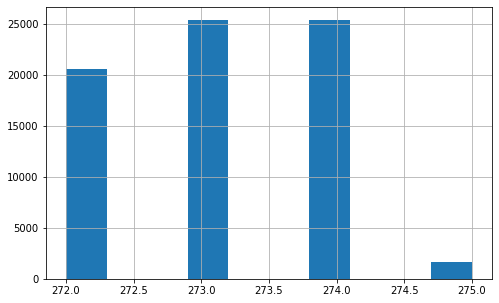

In [ ]:
pd.Series(df_edit['region']).hist(bins=10, figsize=(8,5))

One-hot encoding apply:

In [ ]:
df_edit['region'] = (df_edit['region'] - df_edit['region'].mean()) / df_edit['region'].std()

In [ ]:
# df_edit = pd.get_dummies(df_edit, columns=['region'], dtype=float)

## **Course (*, degs):**

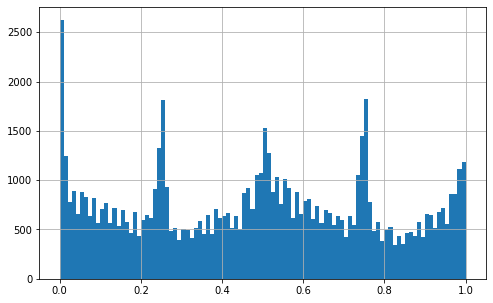

In [ ]:
pd.Series(df_edit['course']).hist(bins=100, figsize=(8,5))

In [ ]:
# z-norm
# df_edit['course'] =  (df_edit['course'] - df_edit['course'].mean()) / df_edit['course'].std()

In [ ]:
# abs max scaling
df_edit['course'] =  df_edit['course'] /  df_edit['course'].abs().max()

## **Velocity:**

In [ ]:
print('(velocity > 12):', df_edit[df_edit.velocity > 12].shape[0])

(velocity > 12): 481


In [ ]:
df_edit = df_edit[df_edit.velocity < 12]
df_edit.shape

(72894, 19)

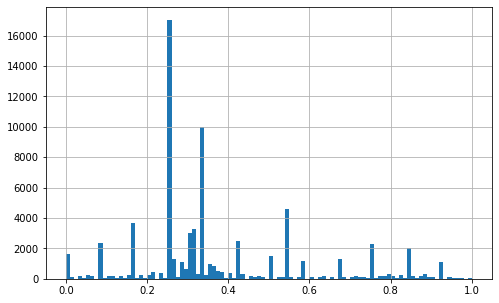

In [ ]:
pd.Series(df_edit['velocity']).hist(bins=100, figsize=(8,5))

Normalization apply:

In [ ]:
# z-norm
#df_edit['velocity'] =  (df_edit['velocity'] - df_edit['velocity'].mean()) / df_edit['velocity'].std()

In [ ]:
# abs max scaling
df_edit['velocity'] = df_edit['velocity'] / df_edit['velocity'].abs().max()

## **Total ton ():**

In [ ]:
print('(total_ton > 400):', df_edit[df_edit.total_ton > 400].shape[0])

(total_ton > 400): 1495


In [ ]:
df_edit = pd.DataFrame(data=df_edit[df_edit.total_ton < 400].values, columns=df_edit.columns)
df_edit.shape

(71263, 18)

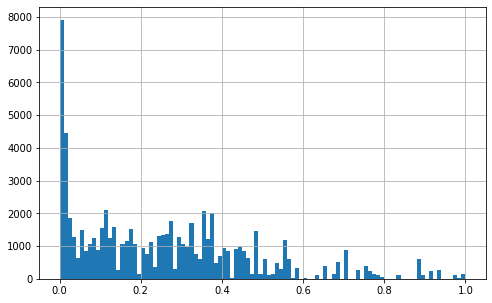

In [ ]:
df_edit['total_ton'].hist(bins=100, figsize=(8,5))

Maximum absolute scaling apply:

In [ ]:
# df_edit['total_ton'] = (df_edit['total_ton'] - df_edit['total_ton'].mean())/ df_edit['total_ton'].std()
# df_edit['total_ton'].min(), df_edit['total_ton'].max()

(-1.1555987578085647, 3.4039690364711057)

In [ ]:
df_edit['total_ton'] = df_edit['total_ton'] / df_edit['total_ton'].abs().max()
df_edit['total_ton'].min(), df_edit['total_ton'].max()

(0.0, 1.0)

## **Idves (ship code) & trawl (fishing gear):**

Standartization:

In [ ]:
df_binary_idves = BinaryEncoder().fit_transform(df_edit['idves'], dtype=float)
df_binary_idves.columns = ([f'i{i}' for i in range(len(df_binary_idves.columns))])

df_binary_trawl = BinaryEncoder().fit_transform(df_edit['trawl'], dtype=float)
df_binary_trawl.columns = ([f't{i}' for i in range(len(df_binary_trawl.columns))])

In [ ]:
df_binary_idves[df_edit.columns] = df_edit
df_binary_idves[df_binary_trawl.columns] = df_binary_trawl
df_edit = df_binary_idves
df_edit = df_edit.drop(columns=['idves', 'trawl'])



> # **Save processed dataset**



In [ ]:
pollok_df = df_edit

In [ ]:
normalized_df = pollok_df.to_csv('/content/drive/MyDrive/Colab Notebooks/AI4Sea/data/normalized_df.csv')



> # **Models construct**



## Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras import layers
from keras import activations
from keras import optimizers

Array-like samples form:

In [ ]:
pip install eco2ai

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # force_remount=True

Mounted at /content/drive


In [ ]:
processed_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI4Sea/data/normalized_df.csv')
processed_df = processed_df.drop(['Unnamed: 0'], axis=1) 
pollok_df = pd.DataFrame(data=processed_df.values.astype(np.float32), columns=processed_df.columns)

In [ ]:
pollok_df

In [ ]:
train_df = pollok_df.sample(frac=0.9, random_state=seed)
test_df = pollok_df[~pollok_df.index.isin(train_df.index)]

In [ ]:
x_train = np.array((train_df.drop(['ton'], axis=1).values))
y_train = np.array(train_df['ton'].values)

x_test = np.array((test_df.drop(['ton'], axis=1).values), )
y_test = np.array(test_df['ton'].values)

print(x_train.shape, y_train.shape) 
print(x_test.shape, y_test.shape)

(63680, 30) (63680,)
(7075, 30) (7075,)


Model:

In [ ]:
%%time
tf.keras.utils.set_random_seed(seed)

model = keras.Sequential([keras.Input(shape=x_test.shape[1]), 
                          layers.Dense(7, activation=activations.tanh), 
                          layers.Dense(15, activation=activations.relu),
                          layers.Dense(15, activation=activations.relu), 
                          layers.Dense(15, activation=activations.relu),
                          layers.Dense(7, activation=activations.relu), 
                          layers.Dense(5, activation=activations.relu), 
                          layers.Dense(1)])

model.compile(loss='mse', optimizer='adamax', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit(x_train, y_train, epochs=150, validation_split=0.05, batch_size=512, verbose=1 )

Epoch 1/150
120/120 [==============================] - 2s 8ms/step - loss: 16.5130 - root_mean_squared_error: 4.0636 - val_loss: 26.1324 - val_root_mean_squared_error: 5.1120
Epoch 2/150
120/120 [==============================] - 1s 5ms/step - loss: 15.7813 - root_mean_squared_error: 3.9726 - val_loss: 25.9097 - val_root_mean_squared_error: 5.0902
Epoch 3/150
120/120 [==============================] - 1s 4ms/step - loss: 15.6309 - root_mean_squared_error: 3.9536 - val_loss: 25.7747 - val_root_mean_squared_error: 5.0769
Epoch 4/150
120/120 [==============================] - 0s 3ms/step - loss: 15.5358 - root_mean_squared_error: 3.9415 - val_loss: 25.7010 - val_root_mean_squared_error: 5.0696
Epoch 5/150
120/120 [==============================] - 0s 4ms/step - loss: 15.4778 - root_mean_squared_error: 3.9342 - val_loss: 25.5967 - val_root_mean_squared_error: 5.0593
Epoch 6/150
120/120 [==============================] - 0s 3ms/step - loss: 15.4374 - root_mean_squared_error: 3.9290 - val_lo

14/14 [==============================] - 0s 3ms/step - loss: 14.1845 - root_mean_squared_error: 3.7662
R2:  0.0829434978623953


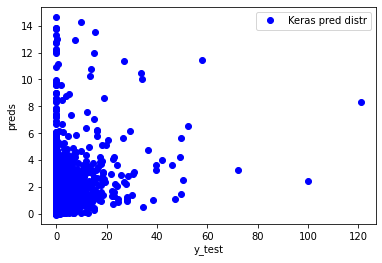

In [ ]:
preds_ker = model.predict(x_test) # 200 epoches
scores = model.evaluate(x_test, y_test, batch_size=512)
R2_keras = r2_score(y_test, preds_ker)
print('R2: ', R2_keras)

plt.plot(y_test, preds_ker, 'o', c = 'b', label = 'Keras pred distr')
plt.ylabel('preds');  
plt.xlabel('y_test');
plt.legend(loc = 'upper right');

## RF

In [ ]:
def RMSE_ar(pred, true):  
    dev = (pred-true)**2    
    return np.sqrt(dev.mean())

In [ ]:
%%time
RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=seed, min_samples_split=7) # random_state=seed
RF_Reg.fit(x_train, y_train)

preds_rf = RF_Reg.predict(x_test)

CPU times: user 5min 50s, sys: 397 ms, total: 5min 50s
Wall time: 5min 52s


R2_score:  0.16478139425439875
RMSE:  3.5942625174959035


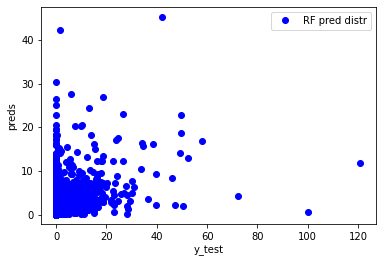

In [ ]:
# RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=42, min_samples_split=7)
RMSE_r = RMSE_ar(y_test, preds_rf)
R2_RF = sklearn.metrics.r2_score(y_test, preds_rf)
print('R2_score: ', R2_RF) 
print('RMSE: ', RMSE_r) 

plt.plot(y_test, preds_rf, 'o', c = 'b', label = 'RF pred distr')
plt.ylabel('preds');  
plt.xlabel('y_test');
plt.legend(loc = 'upper right');

R2_score:  0.16144166359754208
RMSE:  3.601441412223798


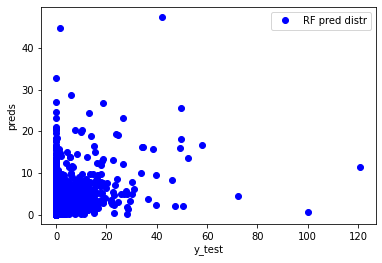

In [ ]:
# RF_Reg = RandomForestRegressor(n_estimators = 500, criterion='squared_error', random_state=42, min_samples_split=5)
RMSE_r = RMSE_ar(y_test, preds_rf)
R2_RF = sklearn.metrics.r2_score(y_test, preds_rf)
print('R2_score: ', R2_RF) 
print('RMSE: ', RMSE_r) 

plt.plot(y_test, preds_rf, 'o', c = 'b', label = 'RF pred distr')
plt.ylabel('preds');  
plt.xlabel('y_test');
plt.legend(loc = 'upper right');